# Harmonizing a test set of FreeSurfer 7.1.1 volumes using NeuroHarmony (COMBAT + MRI-QC)

## E-DADS

### Steps

1. Load FS and MRIQC outputs
2. Wrangle to match `dummy_test.csv` header and divide volumes by `ICV`/`eTIV`
3. Load trained model
4. Run it

### Observations

- Does it work only for cross-sectional test data?

### Authors

- Neil Oxtoby, UCL: step 2 (wrangling)
- Vikram Venkatraghavan, AUMC (everything else)

In [1]:
import pickle 
import pandas as pd 
import numpy as np 
from neuroharmony import Neuroharmony
import warnings 

warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path

## EDIT ME: Paths to data, CSV filenames, etc.

In [42]:
# CHANGE ME
edads_folder = Path.home() / "Documents" / "research-projects" / "E-DADS_MR-T046422-1"
top_folder = edads_folder / "projects" / "2023-05_Harmonization_Paper" / "20231023-Model_For_Harmonizing_AIBL"
csv_aibl_demographics = top_folder / 'AIBLMERGE_freesurfer7p1p1-20220915.csv'
csv_test_freesurfer7p1p1 = top_folder / 'aibl_freesurfer7p1p1_frompierrick.csv'
tsv_test_mriqc0p16p1     = top_folder / 'aibl_mriqc_from_pierrick.tsv'

csv_test_wrangled   = top_folder / 'aibl_test_for_neuroharmony.csv'
csv_test_harmonised = Path(str(csv_test_wrangled).replace('.csv','-harmonised.csv'))

str_pickle = top_folder / 'pickle_files'

if 'noxtoby' in str(Path().home()):
    # Neil's path
    str_pickle = Path.home() / "Library/CloudStorage/OneDrive-UniversityCollegeLondon/Data-from-Neil-Oxtoby/E-DADS_harmonization/raw"


## Dummy CSV for correct formatting

In [4]:
csv_dummy_test = top_folder / 'dummy_test.csv'
df_dummy_test = pd.read_csv(csv_dummy_test)

## CHECK ME: Load data

- Columns may need renaming
- Coding may need checking:
  - `Sex`: {0:'Male',1:'Female'}
  - `Diagnosis`: 0 unimpaired; 1 impaired
  - `scanner`: TBD
  - `cohort`: Just give it a name

In [5]:
key = ['ID','visit'] # for merging tables

In [6]:
df_test_mriqc = pd.read_csv(tsv_test_mriqc0p16p1,sep='\t')

df_test_fs    = pd.read_csv(csv_test_freesurfer7p1p1)
# Rename columns
df_test_fs.rename(columns={'rid':'ID'},inplace=True)

In [7]:
df_aibl_demog = pd.read_csv(csv_aibl_demographics)
# Rename column(s)
df_aibl_demog.rename(columns={'TP':'visit'},inplace=True)
# Recode
df_aibl_demog['Sex_text'] = df_aibl_demog['Sex'].values
df_aibl_demog['Sex'] = df_aibl_demog['Sex'].map({"M":0,"F":1})
df_aibl_demog['Diagnosis'] = df_aibl_demog['Diagnostic Criteria'].map({'CN':0,'MCI':1,'AD':1})

# Add `cohort` column
df_aibl_demog['cohort'] = 'AIBL-LONI'

## Have a quick squiz at the data

In [8]:
df_aibl_demog.drop_duplicates(subset=key,inplace=True) # Why are there always duplicates?
df_aibl_demog.head()

,ID,visit,Age,Sex,APOE Genotype,Family History of AD,Diagnostic Criteria,SMC,Amnestic_MCI,Staging Information 1,...,Entorhinal,MidTemp,Fusiform,WholeBrain,RID,LIMMTOTAL,LDELTOTAL,Sex_text,Diagnosis,cohort
0,1000,T0,67,1,1.0,NaN,CN,non_SMC,NaN,NaN,...,4031.0,21171.0,19441.0,1.066988e+06,1000.0,18.0,19.0,F,0,AIBL-LONI
1,1000,T4,73,1,1.0,NaN,CN,SMC,NaN,NaN,...,4156.0,20185.0,18836.0,1.040200e+06,1000.0,15.0,14.0,F,0,AIBL-LONI
2,1001,T0,74,0,0.0,0.0,CN,SMC,NaN,NaN,...,3601.0,21642.0,18884.0,1.190431e+06,1001.0,14.0,14.0,M,0,AIBL-LONI
3,1001,T4,80,0,0.0,0.0,CN,SMC,NaN,NaN,...,3355.0,19978.0,17881.0,1.159274e+06,1001.0,8.0,10.0,M,0,AIBL-LONI
4,1005,T0,83,1,0.0,NaN,MCI,NaN,amnestic,NaN,...,3659.0,24431.0,16362.0,1.019918e+06,1005.0,7.0,2.0,F,1,AIBL-LONI


In [9]:
df_dummy_test.head()

,ID,cohort,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,CSF,Left-Accumbens-area,...,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max,eTIV,Sex,Age,Diagnosis,scanner


In [10]:
df_test_fs.head()

,ID,visit,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,...,TotalGrayVol,SupraTentorialVol,SupraTentorialVolNotVent,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
0,1000,T0,2.245,2.520,2.686,1.893,3.915,2.726,2.353,2.625,...,593235.835324,964769.0,940592.0,1519904.0,0.764540,1.065078,4.0,2.0,6.0,1.427035e+06
1,1000,T4,2.330,2.636,2.644,1.918,3.881,2.706,2.365,2.525,...,574530.249295,943973.0,913245.0,1523438.0,0.754615,1.073630,8.0,5.0,13.0,1.418960e+06
2,1001,T0,2.238,2.195,2.376,1.878,2.886,2.472,2.195,2.605,...,647430.772769,1066946.0,1033226.0,1707999.0,0.750956,1.048669,13.0,14.0,27.0,1.628731e+06
3,1001,T4,2.185,2.465,2.395,1.811,2.687,2.483,2.134,2.523,...,631001.208617,1048620.0,1005477.0,1719333.0,0.738628,1.055936,14.0,14.0,28.0,1.628255e+06
4,1005,T0,2.449,2.240,2.603,1.719,3.415,2.757,2.487,2.747,...,599994.335508,955428.0,904610.0,1606133.0,0.696542,1.044278,23.0,32.0,55.0,1.538032e+06


In [11]:
df_test_mriqc.head()

,bids_name,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,...,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max
0,sub-1000_ses-T0_T1w,0.382212,3.467063,0.499577,1296.524325,3.189777,3.022030,3.48659,3.06071,0.204237,...,999.373290,999.999970,157959.0,918.943058,1077.659019,48.382183,0.171799,0.421620,0.496217,0.518994
1,sub-1000_ses-T4_T1w,0.397229,3.420390,0.512767,1018.732849,3.305393,3.137868,3.63590,3.14241,0.222639,...,998.887906,1000.000022,150262.0,914.085652,1080.415496,50.635469,0.165782,0.417540,0.492620,0.506815
2,sub-1001_ses-T0_T1w,0.491433,2.667102,0.564244,905.224953,3.050460,2.950650,3.28131,2.91942,0.222931,...,999.652766,999.999994,138885.0,892.121260,1105.901389,65.099649,0.151127,0.381410,0.454995,0.479610
3,sub-1001_ses-T4_T1w,0.526030,2.548132,0.578621,765.413498,2.821258,2.747403,2.98616,2.73021,0.218105,...,998.613229,1000.043327,127608.0,893.718374,1098.603875,62.167001,0.145214,0.368757,0.435506,0.471534
4,sub-1005_ses-T0_T1w,0.424221,3.230201,0.488442,2631.369385,3.500127,3.414811,3.51993,3.56564,0.221531,...,998.140985,1000.054765,155240.0,899.556381,1089.818717,57.677134,0.164844,0.406465,0.456371,0.453744


## EDIT ME: Data wrangling

This is likely to be specific to your CSVs. What I did:

- MRIQC
  - Added "ID" and "visit", based on the available BIDS name (sub/ses). For joining with FreeSurfer.
- FreeSurfer
  - Removed duplicates (subset=['ID','visit']), preferring those with fewer `SurfaceHoles`

In [12]:
# MRIQC
print("Wrangling MRIQC\n")

# Add ID 
df_test_mriqc['ID'] = df_test_mriqc['bids_name'].map(lambda x: x.split('_ses')[0].split('sub-')[-1]).astype(int)
# Add visit
df_test_mriqc['visit'] = df_test_mriqc['bids_name'].map(lambda x: x.split('_ses-')[-1].split('_T1')[0])
# Reorder columns
df_test_mriqc = df_test_mriqc[key + [c for c in df_test_mriqc.columns.tolist() if c not in key]]
df_test_mriqc.head()

Wrangling MRIQC



,ID,visit,bids_name,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,...,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max
0,1000,T0,sub-1000_ses-T0_T1w,0.382212,3.467063,0.499577,1296.524325,3.189777,3.022030,3.48659,...,999.373290,999.999970,157959.0,918.943058,1077.659019,48.382183,0.171799,0.421620,0.496217,0.518994
1,1000,T4,sub-1000_ses-T4_T1w,0.397229,3.420390,0.512767,1018.732849,3.305393,3.137868,3.63590,...,998.887906,1000.000022,150262.0,914.085652,1080.415496,50.635469,0.165782,0.417540,0.492620,0.506815
2,1001,T0,sub-1001_ses-T0_T1w,0.491433,2.667102,0.564244,905.224953,3.050460,2.950650,3.28131,...,999.652766,999.999994,138885.0,892.121260,1105.901389,65.099649,0.151127,0.381410,0.454995,0.479610
3,1001,T4,sub-1001_ses-T4_T1w,0.526030,2.548132,0.578621,765.413498,2.821258,2.747403,2.98616,...,998.613229,1000.043327,127608.0,893.718374,1098.603875,62.167001,0.145214,0.368757,0.435506,0.471534
4,1005,T0,sub-1005_ses-T0_T1w,0.424221,3.230201,0.488442,2631.369385,3.500127,3.414811,3.51993,...,998.140985,1000.054765,155240.0,899.556381,1089.818717,57.677134,0.164844,0.406465,0.456371,0.453744


In [13]:
# FreeSurfer
print("Identifying duplicates in FreeSurfer CSV\n")

print(f"Not sure why there are {key} duplicates in FreeSurfer, but they tend to differ by SurfaceHoles so perhaps that's useful:\n")
idx = list(df_test_fs.drop_duplicates(subset=key).index.values)
list(df_test_fs.index.values)
idx_having_duplicates = [ i for i in list(df_test_fs.index.values) if i not in idx ]
df_test_fs.loc[df_test_fs['ID'].isin(df_test_fs.loc[idx_having_duplicates,'ID'].tolist())].sort_values(by=key)

Identifying duplicates in FreeSurfer CSV

Not sure why there are ['ID', 'visit'] duplicates in FreeSurfer, but they tend to differ by SurfaceHoles so perhaps that's useful:



,ID,visit,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,...,TotalGrayVol,SupraTentorialVol,SupraTentorialVolNotVent,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
343,181,T0,2.359,2.223,2.422,1.834,2.756,2.553,2.356,2.635,...,599054.770563,949724.0,921533.0,1526851.0,0.755261,1.051332,13.0,7.0,20.0,1.452301e+06
344,181,T2,2.222,2.189,2.218,1.820,3.012,2.556,2.246,2.486,...,574225.673102,936580.0,906354.0,1500288.0,0.773236,1.073041,7.0,7.0,14.0,1.398165e+06
345,181,T2,2.222,2.189,2.218,1.820,3.012,2.556,2.246,2.486,...,593092.826188,964225.0,927065.0,1528272.0,0.738567,1.037393,12.0,4.0,16.0,1.473185e+06
350,185,T0,2.198,2.098,2.148,1.809,3.207,2.497,2.134,2.467,...,524030.026292,884269.0,841701.0,1433667.0,0.744990,1.081155,17.0,15.0,32.0,1.326052e+06
351,185,T0,2.198,2.098,2.148,1.809,3.207,2.497,2.134,2.467,...,537971.991883,868899.0,833332.0,1380248.0,0.779668,1.097096,23.0,17.0,40.0,1.258092e+06
352,259,T0,2.592,2.640,2.463,1.847,2.697,2.612,2.314,2.642,...,524030.026292,884269.0,841701.0,1433667.0,0.744990,1.081155,17.0,15.0,32.0,1.326052e+06
353,259,T0,2.592,2.640,2.463,1.847,2.697,2.612,2.314,2.642,...,537971.991883,868899.0,833332.0,1380248.0,0.779668,1.097096,23.0,17.0,40.0,1.258092e+06
426,259,T1,2.659,2.696,2.482,1.981,2.782,2.624,2.269,2.633,...,532191.455603,849715.0,809744.0,1375407.0,0.771626,1.105482,25.0,22.0,47.0,1.244170e+06
346,403,T1,2.445,2.144,2.448,1.942,3.146,2.574,2.280,2.687,...,574225.673102,936580.0,906354.0,1500288.0,0.773236,1.073041,7.0,7.0,14.0,1.398165e+06
347,403,T1,2.445,2.144,2.448,1.942,3.146,2.574,2.280,2.687,...,593092.826188,964225.0,927065.0,1528272.0,0.738567,1.037393,12.0,4.0,16.0,1.473185e+06


In [14]:
# FreeSurfer
print("Wrangling FreeSurfer\n")

print(f"Before: df.shape: {df_test_fs.shape}")
# Drop duplicates
df_test_fs = df_test_fs.sort_values(by=key+['SurfaceHoles']).drop_duplicates(subset=key).reset_index(drop=True)
print(f"After:  df.shape: {df_test_fs.shape}")

Wrangling FreeSurfer

Before: df.shape: (1056, 205)
After:  df.shape: (1050, 205)


## Merge FreeSurfer and MRIQC

Then match columns with `dummy_test.csv`

- Extract missing ones from wherever I can

In [15]:
df_test = pd.merge(df_test_fs,df_test_mriqc,on=['ID','visit'],how='inner')

In [16]:
# print(f"df_test_fs.shape   : {df_test_fs.shape}")
# print(f"df_test_fs.drop_duplicates().shape   : {df_test_fs.drop_duplicates(subset=key).shape}")
# print("")
# print(f"df_test_mriqc.shape: {df_test_mriqc.shape}")
# print(f"df_test_mriqc.drop_duplicates().shape   : {df_test_mriqc.drop_duplicates(subset=key+['bids_name']).shape}")
# print("")
# print(f"df_test.shape      : {df_test.shape}")
# print(f"df_test.drop_duplicates().shape      : {df_test.drop_duplicates(subset=key).shape}")

## Match test data columns to dummy

In [17]:
# Harmonise the columns
in_both_dummy_and_test = [c for c in df_test.columns.tolist() if c in df_dummy_test.columns.tolist()]
in_test_and_not_dummy  = [c for c in df_test.columns.tolist() if c not in df_dummy_test.columns.tolist()]
in_dummy_and_not_test  = [c for c in df_dummy_test.columns.tolist() if c not in df_test.columns.tolist()]

# print(f'In both dummy and real:\n{", ".join(in_both_dummy_and_test)}\n')
# print("")

print(f'In dummy but not real (add these from AIBL):\n{", ".join(in_dummy_and_not_test)}\n')

# print("")
# print(f'In real  but not dummy:\n{", ".join(in_test_and_not_dummy)}')

In dummy but not real (add these from AIBL):
cohort, Sex, Age, Diagnosis, scanner



In [18]:
in_demog = ['cohort','Age','Sex','Diagnosis']
df_aibl_demog[in_demog]

,cohort,Age,Sex,Diagnosis
0,AIBL-LONI,67,1,0
1,AIBL-LONI,73,1,0
2,AIBL-LONI,74,0,0
3,AIBL-LONI,80,0,0
4,AIBL-LONI,83,1,1
...,...,...,...,...
1074,AIBL-LONI,80,1,1
1075,AIBL-LONI,62,0,1
1076,AIBL-LONI,63,0,1
1077,AIBL-LONI,84,0,0


In [19]:
print(f"Demographics merge.\nBefore: df.shape: {df_test.shape}")
df_test = pd.merge(df_test,df_aibl_demog[key + in_demog],on=key,how='inner')
print(f"After:  df.shape: {df_test.shape}")

Demographics merge.
Before: df.shape: (1050, 274)
After:  df.shape: (1050, 278)


## FIXME: get `scanner` information from somewhere

In [20]:
df_test['scanner'] = 'Unknown'

In [21]:
colz = df_dummy_test.columns.tolist()
df_test = df_test[colz].copy()

## Wrangling: dividing test volumes by TIV

In [22]:
df_test.columns.tolist()

['ID',
 'cohort',
 'Left-Thalamus',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'CSF',
 'Left-Accumbens-area',
 'Right-Thalamus',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'BrainSegVol',
 'BrainSegVolNotVent',
 'TotalGrayVol',
 'lh_bankssts_volume',
 'lh_caudalanteriorcingulate_volume',
 'lh_caudalmiddlefrontal_volume',
 'lh_cuneus_volume',
 'lh_entorhinal_volume',
 'lh_fusiform_volume',
 'lh_inferiorparietal_volume',
 'lh_inferiortemporal_volume',
 'lh_isthmuscingulate_volume',
 'lh_lateraloccipital_volume',
 'lh_lateralorbitofrontal_volume',
 'lh_lingual_volume',
 'lh_medialorbitofrontal_volume',
 'lh_middletemporal_volume',
 'lh_parahippocampal_volume',
 'lh_paracentral_volume',
 'lh_parsopercularis_volume',
 'lh_parsorbitalis_volume',
 'lh_parstriangularis_volume',
 'lh_pericalcarine_volume',
 'lh_postcentral_volume',
 'lh_posteriorcingulate_volume',
 'lh_

In [23]:
vols = [c for c in df_test.columns.tolist() if ( 'vol' in str.lower(c) ) | ( 'left' in str.lower(c) ) | ( 'right' in str.lower(c) ) | (c=='CSF')]
tiv_col = 'eTIV'
for v in vols:
    df_test[v] = df_test[v]/df_test[tiv_col]


## Write out to CSV

In [24]:
df_test.to_csv(csv_test_wrangled,index=False)
print(f"Wrangled test data written out to {csv_test_wrangled.name}")

Wrangled test data written out to aibl_test_for_neuroharmony.csv


<hr/>

<hr/>

<hr/>


## Load the wrangled test data

In [25]:
Xtest = pd.read_csv(csv_test_wrangled, low_memory=False)
# Xtest needs to be in the format mentioned in dummy_test.csv 
# Note: The volumes should be expressed as fractions of eTIV
# Sex --> should be 0 / 1 {0 for male, 1 for female}
# Diagnosis --> should be 0 / 1 {0 for unimpaired cognition, 1 otherwise}


<hr/>

## Vikram's code from here

Contains some magic parameters based on the prescribed format for TEST data



In [48]:
rois = list(Xtest)[2:88]
regression_features = list(Xtest)[88:157]

# Neil code
testing_on_single_roi = True 
if testing_on_single_roi:
    #rois = [rois[0]]
    rois = ['lh_parahippocampal_volume']
# END Neil code

covariates = ["Sex", "scanner", 'Age','Diagnosis']
eliminate_variance = ["scanner"]
discrete_cols = ['Sex','Diagnosis']
continuous_cols = ['Age']

Xtest_prepared = Xtest[['ID','cohort']+rois+regression_features+covariates].copy(deep=True)
Xharmonized = Xtest_prepared.copy(deep=True)

from tqdm import tqdm

for r in tqdm(rois):
    model = Neuroharmony(
        [r],
        regression_features,
        covariates,
        eliminate_variance,
        discrete_cols = discrete_cols,
        continuous_cols = continuous_cols,
        param_distributions=dict(
            RandomForestRegressor__n_estimators=[100, 200, 500],
            RandomForestRegressor__random_state=[42, 78],
            RandomForestRegressor__warm_start=[False, True],
        ),
        estimator_args=dict(n_jobs=64, random_state=42),
        randomized_search_args=dict(cv=5,n_jobs=64)
    )

    pickle_name = str_pickle / (r + '.pickle') # Edited by Neil

    # Added by Neil
    if not pickle_name.exists():
        print(f"{pickle_name.name} file not found. Looking for zip file.")
        pickle_name_zip = Path(str(pickle_name) + '.gz')
        if pickle_name_zip.exists():
            raise NotImplementedError(f"{pickle_name_zip.name} zip-file found. Extracting (FIXME: not implemented).")
        else:
            print(f"{pickle_name_zip.name} zip-file not found.")

    [model_roi,coverage_roi] = pickle.load(open(pickle_name,'rb'))

    model.models_by_feature_ = dict.fromkeys([r],model_roi)
    model.coverage_ = coverage_roi
    model.extra_vars = regression_features+covariates
    Xp=model.predict(Xtest_prepared)
    Xharmonized[r] = Xp[r].copy(deep=True)
    del model


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


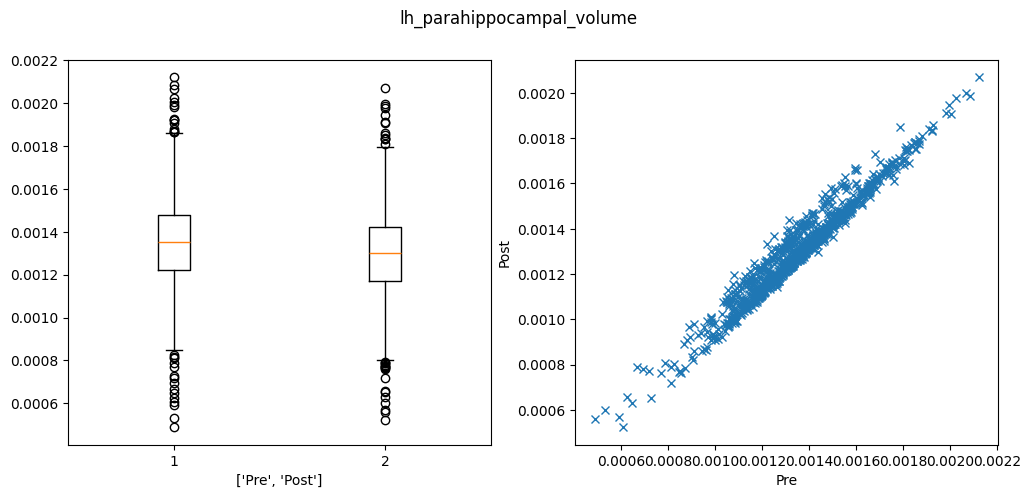

In [52]:
if testing_on_single_roi:
    from matplotlib import pyplot as plt
    #import seaborn
    fig,ax=plt.subplots(1,2,figsize=(12,5))
    ax[0].boxplot([Xtest_prepared[r],Xharmonized[r]])
    ax[0].set_xlabel(['Pre','Post'])
    ax[1].plot(Xtest_prepared[r],Xharmonized[r],'x')
    ax[1].set_xlabel('Pre')
    ax[1].set_ylabel('Post')
    fig.suptitle(r)
    fig.show()

# Write to file

In [ ]:
Xharmonized.to_csv(csv_test_harmonised, index=False)